In [6]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.functional import F
from sklearn import metrics
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline
import numpy as np
from utils import plot_confusion_matrix

In [7]:
dataset_x = torch.load("dataset/dataset_x")
dataset_y = torch.load("dataset/dataset_y")
x_train,x_test,y_train,y_test = train_test_split(dataset_x,dataset_y,test_size=0.2,random_state=1)

In [8]:
class BiRNN(nn.Module):
    def __init__(self, embed_size, num_hiddens, num_layers, classes):
        super(BiRNN, self).__init__()
        # bidirectional设为True即得到双向循环神经网络

        self.encoder = nn.LSTM(input_size=embed_size,
                               hidden_size=num_hiddens,
                               num_layers=num_layers,
                               bidirectional=True)
        
        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        self.classifier = nn.Sequential(
            nn.Linear(4*num_hiddens, 32*num_hiddens),
            # nn.BatchNorm1d(2*num_hiddens),
            nn.Sigmoid(),
            nn.Linear(32*num_hiddens,classes)
        )


    def forward(self, inputs):
        # inputs的形状是(批量大小, 词数, 词向量维度)，因为LSTM需要将序列长度(seq_len)作为第一维，所以将输入转置后
        # 再提取词特征，输出形状为(词数, 批量大小, 词向量维度)
        inputs = torch.transpose(inputs, 0, 1)
        # outputs形状是(词数, 批量大小, 2 * 隐藏单元个数)
        outputs, _ = self.encoder(inputs)  # output, (h, c)
        # 连结初始时间步和最终时间步的隐藏状态作为全连接层输入。它的形状为 (批量大小, 4 * 隐藏单元个数)。
        outs = torch.cat((outputs[0], outputs[-1]), -1)
        outs = self.classifier(outs)
        return outs

In [9]:
model = BiRNN(embed_size=100, num_hiddens=100, num_layers=5, classes=5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
def batch_padding(batch_data):
    # 针对一批句子的长度（词向量个数）不一样时，全部补0到最大句子长度
    new_batch_data = []
    max_len = 0
    for s in batch_data:
        s = torch.tensor(s)
        new_batch_data.append(s)
        max_len = max(max_len,s.shape[0])
    for i in range(len(new_batch_data)):
        new_batch_data[i] = F.pad(new_batch_data[i], [0, 0, 0, max_len-new_batch_data[i].shape[0]])
    return torch.stack(new_batch_data, 0)	

In [11]:
sentences = batch_padding(dataset_x[0:5])
sentences.shape # [batch_size,句子中词的个数,词向量维度]

torch.Size([5, 15, 100])

In [12]:
print(model(sentences.to(device))) # 输出为OneHot编码形式

tensor([[ 0.2589,  0.3352, -0.1296, -0.1579,  0.2588],
        [ 0.2585,  0.3354, -0.1296, -0.1580,  0.2584],
        [ 0.2588,  0.3353, -0.1295, -0.1578,  0.2589],
        [ 0.2588,  0.3353, -0.1295, -0.1579,  0.2590],
        [ 0.2588,  0.3353, -0.1295, -0.1579,  0.2589]], device='cuda:0',
       grad_fn=<AddmmBackward>)


## 训练

In [13]:
def train(model,dataset_x,dataset_y,num_epochs,
batch_size,optimizer,loss,batch_loss_list,batch_acc_list):
    model.train()
    for epoch in range(num_epochs):
        print("epoch",epoch)
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        batch_num = len(dataset_x) // batch_size
        for i in range(batch_num):
            X = batch_padding(dataset_x[i*batch_size : (i+1)*batch_size]).to(device)
            y = torch.tensor(dataset_y[i*batch_size : (i+1)*batch_size]).to(device)
            y_hat = model(X)
            y = y.argmax(dim=1).long()
            loss_ = loss(y_hat, y)
            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()

            batch_loss = loss_.cpu().item()
            batch_acc = (y_hat.argmax(dim=1) == y).sum().cpu().item()
            batch_loss_list.append(batch_loss/batch_size)
            batch_acc_list.append(batch_acc/batch_size)
            print(f"epoch:{epoch},batch loss:{batch_loss/batch_size},batch acc:{batch_acc/batch_size}")
        

In [14]:
lr = 0.001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr=lr)
loss = nn.CrossEntropyLoss().to(device) 

In [98]:
batch_loss_list = []
batch_acc_list = []

In [99]:
print("training... ")
train(model=model,dataset_x=x_train,dataset_y=y_train,
num_epochs=10,batch_size=256,optimizer=optimizer,loss=loss,
batch_loss_list=batch_loss_list,batch_acc_list=batch_acc_list)
torch.save(model,"models/BiLSTM_v2.npy")

training... 
epoch 0
epoch:0,batch loss:0.007100393995642662,batch acc:0.0546875
epoch:0,batch loss:0.004043997265398502,batch acc:0.71875
epoch:0,batch loss:0.005132361780852079,batch acc:0.70703125
epoch:0,batch loss:0.005166981369256973,batch acc:0.70703125
epoch:0,batch loss:0.004746653605252504,batch acc:0.71484375
epoch:0,batch loss:0.004401559941470623,batch acc:0.71875
epoch:0,batch loss:0.00489039346575737,batch acc:0.70703125
epoch:0,batch loss:0.004220686852931976,batch acc:0.69140625
epoch:0,batch loss:0.004051821306347847,batch acc:0.6953125
epoch:0,batch loss:0.004080289974808693,batch acc:0.72265625
epoch:0,batch loss:0.004090174101293087,batch acc:0.71875
epoch:0,batch loss:0.0040854839608073235,batch acc:0.7265625
epoch:0,batch loss:0.0037703956477344036,batch acc:0.75
epoch:0,batch loss:0.004216415341943502,batch acc:0.69140625
epoch:0,batch loss:0.004199444316327572,batch acc:0.6953125
epoch:0,batch loss:0.003767306450754404,batch acc:0.73046875
epoch:0,batch loss:0.

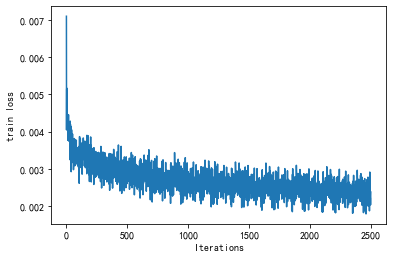

In [106]:
plt.xlabel('Iterations')
plt.ylabel('train loss')
plt.plot(np.arange(len(batch_loss_list)), batch_loss_list)

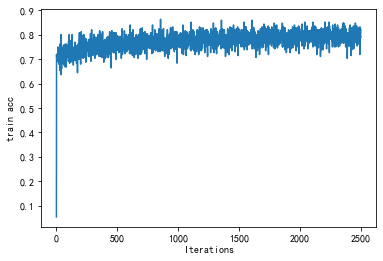

In [107]:
plt.xlabel('Iterations')
plt.ylabel('train acc')
plt.plot(np.arange(len(batch_acc_list)), batch_acc_list)

## 测试

In [15]:
def test(model,dataset_x,dataset_y,pred_list,real_list):
    model.eval()
    for i in range(len(dataset_x)):
        X = torch.tensor([dataset_x[i]]).to(device)
        y = torch.tensor([dataset_y[i]]).to(device)
        y_hat = model(X)
        pred_list.append(y_hat.argmax(dim=1).cpu().item())
        real_list.append(y.argmax(dim=1).cpu().item())

In [16]:
model = torch.load("models/BiLSTM_v2.npy")
pred_list = []
real_list = []
print("testing... ")
test(model,x_test,y_test,pred_list,real_list)
print(metrics.classification_report(real_list,pred_list))

testing... 
              precision    recall  f1-score   support

           0       0.82      0.42      0.55      2396
           1       0.52      0.15      0.23       731
           2       0.53      0.06      0.11       786
           3       0.82      0.48      0.60       883
           4       0.78      0.97      0.87     11256

    accuracy                           0.78     16052
   macro avg       0.69      0.41      0.47     16052
weighted avg       0.76      0.78      0.74     16052



显示百分比：
[[ 0.42  0.00  0.00  0.01  0.57]
 [ 0.04  0.15  0.01  0.01  0.80]
 [ 0.01  0.00  0.06  0.00  0.92]
 [ 0.01  0.05  0.00  0.48  0.46]
 [ 0.01  0.00  0.00  0.01  0.97]]


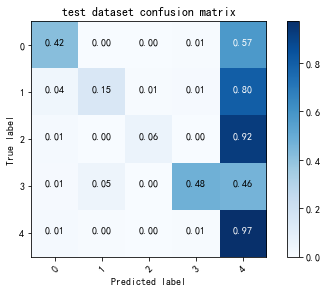

In [17]:
cm = metrics.confusion_matrix(real_list,pred_list)
plot_confusion_matrix(cm,range(5),normalize=True,title='test dataset confusion matrix')